## Assignment 5 - IBM machine learning

Deep Learning - image classification using a convolutional neural networks in a dataframe obtained from Kaggle named Intel Image Classification.

#### The data is divided into 6 different classes:

* 1) Buildings;
* 2) Forest;
* 3) Glacier;
* 4) Mountain;
* 5) Sea;
* 6) Street.


* **14034** images on train data and **3000** on test data.
* Images are **150x150 pixels** and **RGB** color format.
* ***Dataset URL:*** (https://www.kaggle.com/datasets/puneet6060/intel-image-classification/download)

## 1) Exploratory Data Analysis, Visualization, and Preprocessing

In [18]:
#Imporging needed modules
import tensorflow.keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns

In [32]:
#Loading the validation and testing dataset

# 14034 images contained in the train data
# 3000 images contained in the test data

train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    directory='seg_train/',
    labels='inferred',
    label_mode='categorical',
    image_size=(150, 150),
    batch_size = 32,
    seed = 0,
    shuffle=True)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    directory='seg_test/',
    labels='inferred',
    label_mode='categorical',
    image_size=(150, 150),
    batch_size = 32,
    seed = 0,
    shuffle=True)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [466]:
# Checking train x test split proportion
train = pd.DataFrame (None, columns = class_names)
test = pd.DataFrame (None, columns = class_names)

for image_batch, labels_batch in train_ds:
    dataframe = pd.DataFrame (labels_batch, columns = class_names)
    train = pd.concat ([dataframe, train])
train = len(train)

for image_batch, labels_batch in validation_ds:
    dataframe = pd.DataFrame (labels_batch, columns = class_names)
    test = pd.concat ([dataframe, test])
test = len(test)  

percentage_train = round (train/(train+test)*100, 2)
percentage_test = round (test/(train+test)*100, 2)

print ('Train:', str (percentage_train)+'%',
       '; Test:', str (percentage_test)+'%')

Train: 82.39% ; Test: 17.61%


In [175]:
# Checking Class names - 6 classes found:
print (validation_ds.class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [735]:
#Seeing image shape:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape[1:], '-> Original 150x150 pixels and RGB colors (3 layers).')
    print(labels_batch.shape, '-> batch size of 32 images divided into 6 different classes (labels).')
    break

(150, 150, 3) -> Original 150x150 pixels and RGB colors (3 layers).
(32, 6) -> batch size of 32 images divided into 6 different classes (labels).


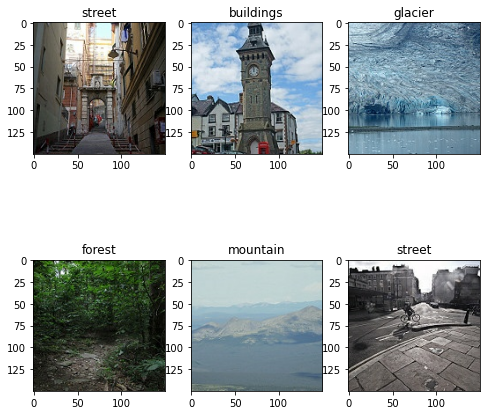

In [272]:
#Seeing a random images with their respective labels from the dataset
#Checking if the correct labels were assigned to each image
class_names = train_ds.class_names

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("on")
        plt.title(class_names[np.argmax(labels[i])])

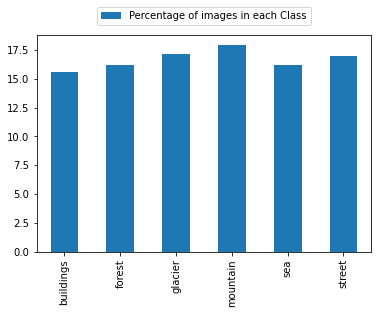

In [467]:
#Seeing image distribution in each Class
concat = pd.DataFrame (None, columns = class_names)
for image_batch, labels_batch in train_ds:
    dataframe = pd.DataFrame (labels_batch, columns = class_names)
    concat = pd.concat ([dataframe, concat])
concat_summary = pd.DataFrame (np.sum(concat)/len(concat)*100)
concat_summary = concat_summary.rename ({0:'Percentage of images in each Class'}, axis = 1)
ax = concat_summary.plot.bar()        #The train dataset is approximately balanced, 
ax.legend(loc='upper center',         #which similar number of images in each class.
          bbox_to_anchor=(0.5, 1.15)) #No data balancing is needed in this dataset.                                                 

In [1006]:
#Checking if any normalization or scaling is needed:
for image_batch, labels_batch in train_ds:
    batch_train = pd.DataFrame (image_batch[0][0]) 
    break

#Data is not scaled, ranged from 0 to 255. It needs further scale.
print('Min:',np.min(image_batch[0]),'; Max:',np.max(image_batch[0])) 

Min: 0.0 ; Max: 255.0


In [33]:
#Scaling train and test data
normalization_layer = Rescaling(1./255)

scaled_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
scaled_test_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

for image_batch, labels_batch in scaled_train_ds:
    batch_train = pd.DataFrame (image_batch[0][0]) 
    break

first_image = image_batch[0]

#Data is now properly scaled.
print('Min:',np.min(image_batch[0]),'; Max:',np.max(image_batch[0])) 

Min: 0.0 ; Max: 1.0


## Key EDA findings, data cleaning and preprocessing summary

* **1)** The dataset is composed of 14034 images on the train data, which correspond to 82% of all images (observation). On the other hand, 3000 images were used to validate the data, corresponding to 18%.
   
   
* **2)** Images are 150x150 pixels size and RGB color format (3 layers). A batch size of 30 was selected to undergo the analysis. As previously shown in the visualization step, the data was correctly labeled into six different image classes: buildings, forest, glacier, mountain, sea, and street. The identification between images from the classes glacier and mountain, as well as buildings and street may be hard due to high image similarity.
   
   
* **3)** The train dataset is approximately balanced, ranging from 15% to 18% in each class, indicating a similar number of images per class. Thus, no data balancing was performed for this dataset.
   
   
* **4)** On the other hand, data scaling is needed, since the the numeric values for each pixel ranges from 0 to 255 in the original datasets (corresponding to the RGB scale). Min Max scaler was then applied to properly scale the data, which now varies from 0 to 1. Data must be at the same scale to undergo neural network models.

## 2) Main Objectives

* 1) Build deep learning models using different convolutional neural networks architectures to classify images on the Intel Image dataset. 


* 3) Accompany the models' accuracy during the training steps (accuracy and loss) to avoid overfitting.


* 2) Analyze the overall models effiency in predicting each one of the six classes using classification metrics including accuracy, AUC, and confusion matrices. This step aims to indentify the most efficient model for the selected dataset.

## 3) Deep Learning

### Model 1

In [784]:
#Defining model architecture
model_1 = Sequential()

## 4x4 convolution with 2x2 stride and 32 filters with padding
model_1.add(Conv2D(32, (4, 4), strides = (2 , 2), padding = 'same', 
                   input_shape=(150, 150, 3)))
model_1.add(Activation('relu'))

## Another 4x4 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (4, 4), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.3))

## Flatten layers
model_1.add(Flatten())
model_1.add(Dense(1024))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(6)) #Number of categories
model_1.add(Activation('softmax'))

model_1.summary() #Seeing model architecture

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 75, 75, 32)        1568      
_________________________________________________________________
activation_46 (Activation)   (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 36, 36, 32)        16416     
_________________________________________________________________
activation_47 (Activation)   (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 10368)           

In [785]:
#Compiling the model using adam optimizer and categorical cross entropy 
#to compute the loss
model_1.compile(
        optimizer= tensorflow.keras.optimizers.RMSprop(learning_rate=0.0005, decay=1e-6),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

#Fitting the model
history_model1 = model_1.fit(
                 scaled_train_ds,
                 validation_data=scaled_test_ds,
                 epochs=10,
                 shuffle=True,
                 batch_size = 32)

Epoch 1/10
439/439 [==============================] - 73s 165ms/step - loss: 1.0572 - accuracy: 0.5939 - val_loss: 0.7792 - val_accuracy: 0.7210
Epoch 2/10
439/439 [==============================] - 72s 165ms/step - loss: 0.7474 - accuracy: 0.7265 - val_loss: 1.1107 - val_accuracy: 0.5937
Epoch 3/10
439/439 [==============================] - 72s 164ms/step - loss: 0.6113 - accuracy: 0.7838 - val_loss: 0.6086 - val_accuracy: 0.7843
Epoch 4/10
439/439 [==============================] - 72s 163ms/step - loss: 0.5203 - accuracy: 0.8152 - val_loss: 0.6267 - val_accuracy: 0.7820
Epoch 5/10
439/439 [==============================] - 72s 163ms/step - loss: 0.4396 - accuracy: 0.8487 - val_loss: 0.7084 - val_accuracy: 0.7600
Epoch 6/10
439/439 [==============================] - 72s 164ms/step - loss: 0.3761 - accuracy: 0.8696 - val_loss: 0.7483 - val_accuracy: 0.7717
Epoch 7/10
439/439 [==============================] - 72s 163ms/step - loss: 0.3285 - accuracy: 0.8863 - val_loss: 0.7524 - val_ac

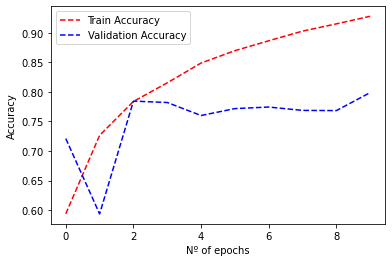

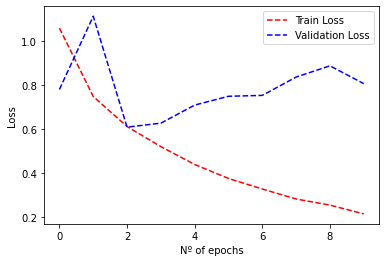

In [1034]:
#Assessing Loss and Accuracy over the epochs

fig, ax1 = plt.subplots()
ax1.plot(history_model1.history["accuracy"],'r--', label="Train Accuracy")
ax1.plot(history_model1.history["val_accuracy"],'b--', label="Validation Accuracy")
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Nº of epochs')
ax1.legend()

fig, ax2 = plt.subplots()
ax2.plot(history_model1.history["loss"],'r--', label="Train Loss")
ax2.plot(history_model1.history["val_loss"],'b--', label="Validation Loss")
ax2.set_ylabel('Loss')
ax2.set_xlabel('Nº of epochs')
ax2.legend()   

#After 2 epochs, only the Train scores benefits from more training, given that 
#only the train accuracy increases and train loss decreases after this time.
#The test accuracy remains the same after the 2 epochs, while the loss increases,
#indicating that the model may be overfitting.

Accuracy: 0.7987 ; AUC: 0.959


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

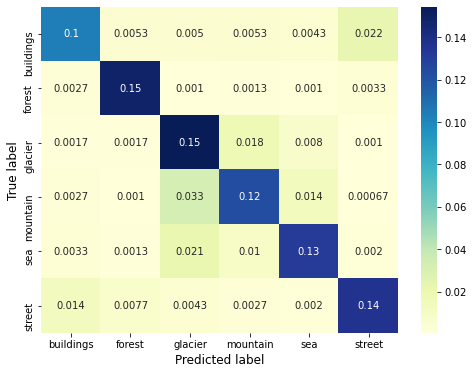

In [1057]:
#Loading again the validation data whithout batch and shuffling observations
#to allow assessing accuracy metrics.

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    directory='seg_test/',
    labels='inferred',
    label_mode='categorical',
    image_size=(150, 150),
    batch_size = 3000,
    seed = 0,
    shuffle=False)

#Rescaling test data
normalization_layer = Rescaling(1./255)
scaled_test_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

#Extracting y_test labels
scaled_test_ds_cache = scaled_test_ds.cache

y_test = pd.DataFrame (None)

for image_batch, labels_batch in scaled_test_ds:
    batch_test = pd.DataFrame (labels_batch)
    y_test = pd.concat([batch_test, y_test])

for element in y_test.columns:
    y_test[element] = y_test[element].map (lambda x: int(x))
    
y_test = y_test.reset_index(drop = True).idxmax(axis = 1)
y_test #Seeing the True labels for the validation dataset

#Predicting labels
y_pred = pd.DataFrame (model_1.predict (scaled_test_ds)).idxmax(axis = 1)
y_proba = model_1.predict (scaled_test_ds)

#Accuracy metrics
acc = accuracy_score (y_test, y_pred)
auc = roc_auc_score (y_test, y_proba, multi_class = 'ovr')
print ('Accuracy:', round(acc,4), '; AUC:', round(auc,4))

cm = confusion_matrix (y_test, y_pred)/3000

import seaborn as sns
plt.figure(figsize=(8, 6))
cm = sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
cm.set_ylabel('True label', fontsize = 12)
cm.set_xlabel('Predicted label', fontsize = 12)
cm
# The model presented high AUC score and relatively high accuracy in classifying the images of Intel dataset.
# Most of the misclassified images were from the class mountain and buildings (true), mainly due to 
# misclassification as glacier and street (predicted), respectively.

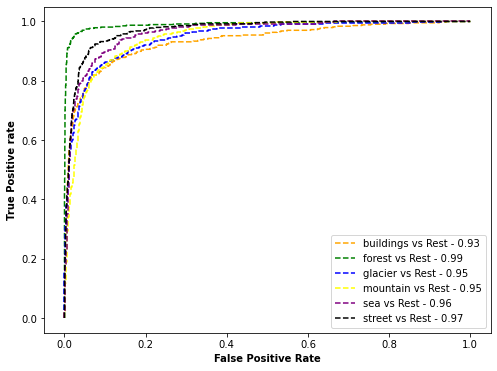

In [1030]:
#Plotting ROC AUC Curve for multiclass
fpr = {}
tpr = {}
thresh ={}
auc = {}

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_proba[:,i], pos_label=i)
    test_prov = y_test.map(lambda x: 1 if x == i else 0)
    auc[i] = roc_auc_score(test_prov, y_proba[:,i])
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=class_names[0]+' vs Rest - '+str(round(auc[0],2)))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=class_names[1]+' vs Rest - '+str(round(auc[1],2)))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=class_names[2]+' vs Rest - '+str(round(auc[2],2)))
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label=class_names[3]+' vs Rest - '+str(round(auc[3],2)))
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label=class_names[4]+' vs Rest - '+str(round(auc[4],2)))
plt.plot(fpr[5], tpr[5], linestyle='--',color='black', label=class_names[5]+' vs Rest - '+str(round(auc[5],2)))
plt.xlabel('False Positive Rate', fontweight = 'bold')
plt.ylabel('True Positive rate', fontweight = 'bold')
plt.legend(loc='best')

# Forest class presented the highest AUC score, indicating that the model presented
# strong ability in distinguish the forest class from the rest (other classes).

## Model 2

In [10]:
#Defining model architecture
model_2 = Sequential()

## 4x4 convolution with 32 filters with padding
model_2.add(Conv2D(32, (3, 3), padding = 'same', 
                   input_shape=(150, 150, 3)))
model_2.add(Activation('relu'))

## Another 4x4 convolution with 32 filters
model_2.add(Conv2D(32, (3, 3), strides = (2,2)))
model_2.add(Activation('relu'))

## 2x2 max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

## 4x4 convolution with 64 filters with padding
model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))

## 4x4 convolution with 64 filters
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))

## Another 2x2 max pooling
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

## Flatten layers
model_2.add(Flatten())
model_2.add(Dense(1024))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(6)) #Number of categories
model_2.add(Activation('softmax'))

model_2.summary() #Seeing model architecture

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 74, 74, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 74, 74, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 64)       

In [11]:
#Compiling the model using adam optimizer and categorical cross entropy 
#to compute the loss
from tensorflow.keras.optimizers import Adam

model_2.compile(loss='categorical_crossentropy',
                optimizer=tensorflow.keras.optimizers.RMSprop(lr=0.0005),
                metrics=['accuracy'])

#Fitting the model
history_model2 = model_2.fit(
                 scaled_train_ds,
                 validation_data=scaled_test_ds,
                 epochs=10,
                 shuffle=True,
                 batch_size = 32)

Epoch 1/10
439/439 [==============================] - 186s 423ms/step - loss: 1.0572 - accuracy: 0.5978 - val_loss: 0.7493 - val_accuracy: 0.7287
Epoch 2/10
439/439 [==============================] - 186s 423ms/step - loss: 0.7108 - accuracy: 0.7347 - val_loss: 0.6756 - val_accuracy: 0.7683
Epoch 3/10
439/439 [==============================] - 185s 422ms/step - loss: 0.5953 - accuracy: 0.7852 - val_loss: 0.5441 - val_accuracy: 0.8053
Epoch 4/10
439/439 [==============================] - 185s 422ms/step - loss: 0.5272 - accuracy: 0.8138 - val_loss: 0.5763 - val_accuracy: 0.8087
Epoch 5/10
439/439 [==============================] - 186s 422ms/step - loss: 0.4809 - accuracy: 0.8311 - val_loss: 0.6446 - val_accuracy: 0.7807
Epoch 6/10
439/439 [==============================] - 186s 424ms/step - loss: 0.4405 - accuracy: 0.8449 - val_loss: 0.5303 - val_accuracy: 0.8260
Epoch 7/10
439/439 [==============================] - 186s 424ms/step - loss: 0.4096 - accuracy: 0.8578 - val_loss: 0.5936 -

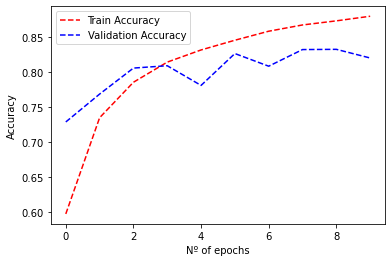

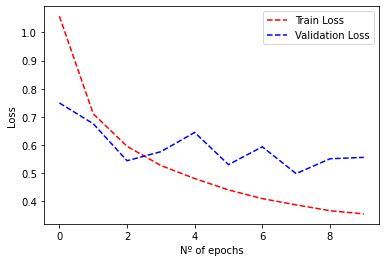

In [12]:
#Assessing Loss and Accuracy over the epochs

fig, ax1 = plt.subplots()
ax1.plot(history_model2.history["accuracy"],'r--', label="Train Accuracy")
ax1.plot(history_model2.history["val_accuracy"],'b--', label="Validation Accuracy")
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Nº of epochs')
ax1.legend()

fig, ax2 = plt.subplots()
ax2.plot(history_model2.history["loss"],'r--', label="Train Loss")
ax2.plot(history_model2.history["val_loss"],'b--', label="Validation Loss")
ax2.set_ylabel('Loss')
ax2.set_xlabel('Nº of epochs')
ax2.legend()

# The train accuracy appeared to be still increasing (slightly) over the 10 epochs,
# while the validation loss slighly decreasing, which suggests that the model may benefit
# with some more training steps. No overftting observed for this model.

Found 3000 files belonging to 6 classes.
Accuracy: 0.8197 ; AUC: 0.971


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

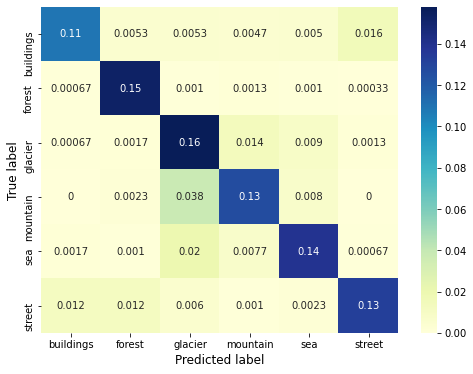

In [16]:
#Loading again the validation data whithout batch and shuffling observations
#to allow assessing accuracy metrics.

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    directory='seg_test/',
    labels='inferred',
    label_mode='categorical',
    image_size=(150, 150),
    batch_size = 3000,
    seed = 0,
    shuffle=False)

#Rescaling test data
normalization_layer = Rescaling(1./255)
scaled_test_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

#Extracting y_test labels
scaled_test_ds_cache = scaled_test_ds.cache

y_test = pd.DataFrame (None)

for image_batch, labels_batch in scaled_test_ds:
    batch_test = pd.DataFrame (labels_batch)
    y_test = pd.concat([batch_test, y_test])

for element in y_test.columns:
    y_test[element] = y_test[element].map (lambda x: int(x))
    
y_test = y_test.reset_index(drop = True).idxmax(axis = 1)
y_test #Seeing the True labels for the validation dataset

#Predicting labels
y_pred = pd.DataFrame (model_2.predict (scaled_test_ds)).idxmax(axis = 1)
y_proba = model_2.predict (scaled_test_ds)

#Accuracy metrics
acc = accuracy_score (y_test, y_pred)
auc = roc_auc_score (y_test, y_proba, multi_class = 'ovr')
print ('Accuracy:', round(acc,4), '; AUC:', round(auc,4))

cm = confusion_matrix (y_test, y_pred)/3000

import seaborn as sns
plt.figure(figsize=(8, 6))
cm = sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
cm.set_ylabel('True label', fontsize = 12)
cm.set_xlabel('Predicted label', fontsize = 12)
cm
# The model presented high AUC score and relatively high accuracy in classifying the images of Intel dataset.
# Most of the misclassified images were from the class mountain (true), mainly due to 
# misclassification as glacier (predicted).

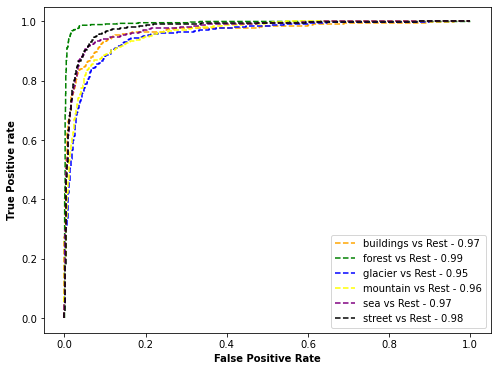

In [19]:
#Plotting ROC AUC Curve for multiclass
fpr = {}
tpr = {}
thresh ={}
auc = {}

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_proba[:,i], pos_label=i)
    test_prov = y_test.map(lambda x: 1 if x == i else 0)
    auc[i] = roc_auc_score(test_prov, y_proba[:,i])
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=class_names[0]+' vs Rest - '+str(round(auc[0],2)))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=class_names[1]+' vs Rest - '+str(round(auc[1],2)))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=class_names[2]+' vs Rest - '+str(round(auc[2],2)))
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label=class_names[3]+' vs Rest - '+str(round(auc[3],2)))
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label=class_names[4]+' vs Rest - '+str(round(auc[4],2)))
plt.plot(fpr[5], tpr[5], linestyle='--',color='black', label=class_names[5]+' vs Rest - '+str(round(auc[5],2)))
plt.xlabel('False Positive Rate', fontweight = 'bold')
plt.ylabel('True Positive rate', fontweight = 'bold')
plt.legend(loc='best')

# Forest class presented the highest AUC score, indicating that the model presented
# strong ability in distinguish the forest class from the rest (other classes).

## Model 3

In [37]:
#Importing ResNet50 architecture
from tensorflow.keras.applications.resnet50 import ResNet50

model_3 = Sequential()

resnet_model= ResNet50(include_top=False,
              input_shape=(150,150,3),
              pooling='avg',classes=6,
              weights='imagenet')

for layer in resnet_model.layers:
        layer.trainable=False

model_3.add(resnet_model)

## Flatten layers
model_3.add(Flatten())
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dense(6, activation='softmax'))

model_3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 6150      
Total params: 25,692,038
Trainable params: 2,104,326
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
#Compiling the model using adam optimizer and categorical cross entropy 
#to compute the loss
from tensorflow.keras.optimizers import Adam

model_3.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

#Fitting the model
history_model3 = model_3.fit(
                 scaled_train_ds,
                 validation_data=scaled_test_ds,
                 epochs=10,
                 shuffle=True,
                 batch_size = 32)

Epoch 1/10
439/439 [==============================] - 331s 750ms/step - loss: 1.3235 - accuracy: 0.4552 - val_loss: 1.0742 - val_accuracy: 0.5503
Epoch 2/10
439/439 [==============================] - 329s 750ms/step - loss: 1.0398 - accuracy: 0.5812 - val_loss: 1.0128 - val_accuracy: 0.5647
Epoch 3/10
439/439 [==============================] - 330s 751ms/step - loss: 0.9568 - accuracy: 0.6164 - val_loss: 0.9247 - val_accuracy: 0.6353
Epoch 4/10
439/439 [==============================] - 328s 748ms/step - loss: 0.9245 - accuracy: 0.6300 - val_loss: 0.8980 - val_accuracy: 0.6287
Epoch 5/10
439/439 [==============================] - 327s 745ms/step - loss: 0.8958 - accuracy: 0.6412 - val_loss: 0.9183 - val_accuracy: 0.6450
Epoch 6/10
439/439 [==============================] - 327s 745ms/step - loss: 0.8788 - accuracy: 0.6496 - val_loss: 0.8698 - val_accuracy: 0.6547
Epoch 7/10
439/439 [==============================] - 326s 742ms/step - loss: 0.8570 - accuracy: 0.6613 - val_loss: 0.8699 -

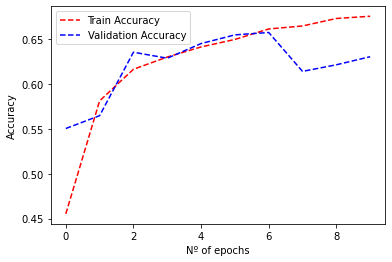

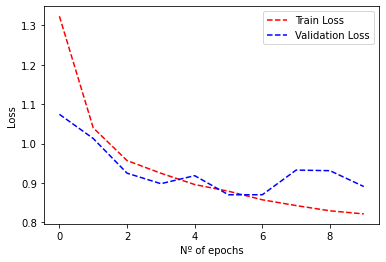

In [39]:
#Assessing Loss and Accuracy over the epochs

fig, ax1 = plt.subplots()
ax1.plot(history_model3.history["accuracy"],'r--', label="Train Accuracy")
ax1.plot(history_model3.history["val_accuracy"],'b--', label="Validation Accuracy")
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Nº of epochs')
ax1.legend()

fig, ax2 = plt.subplots()
ax2.plot(history_model3.history["loss"],'r--', label="Train Loss")
ax2.plot(history_model3.history["val_loss"],'b--', label="Validation Loss")
ax2.set_ylabel('Loss')
ax2.set_xlabel('Nº of epochs')
ax2.legend()   

#After 6 epochs, only the Train scores benefits from more training, given that 
#only the train accuracy increases and train loss decreases after this time.
#The test accuracy remains the same after the 6 epochs, while the loss increases,
#indicating that the model may be overfitting.

Found 3000 files belonging to 6 classes.
Accuracy: 0.6303 ; AUC: 0.924


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

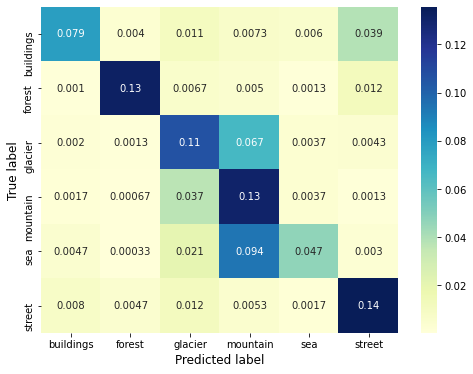

In [40]:
#Loading again the validation data whithout batch and shuffling observations
#to allow assessing accuracy metrics.

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    directory='seg_test/',
    labels='inferred',
    label_mode='categorical',
    image_size=(150, 150),
    batch_size = 3000,
    seed = 0,
    shuffle=False)

#Rescaling test data
normalization_layer = Rescaling(1./255)
scaled_test_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

#Extracting y_test labels
scaled_test_ds_cache = scaled_test_ds.cache

y_test = pd.DataFrame (None)

for image_batch, labels_batch in scaled_test_ds:
    batch_test = pd.DataFrame (labels_batch)
    y_test = pd.concat([batch_test, y_test])

for element in y_test.columns:
    y_test[element] = y_test[element].map (lambda x: int(x))
    
y_test = y_test.reset_index(drop = True).idxmax(axis = 1)
y_test #Seeing the True labels for the validation dataset

#Predicting labels
y_pred = pd.DataFrame (model_3.predict (scaled_test_ds)).idxmax(axis = 1)
y_proba = model_3.predict (scaled_test_ds)

#Accuracy metrics
acc = accuracy_score (y_test, y_pred)
auc = roc_auc_score (y_test, y_proba, multi_class = 'ovr')
print ('Accuracy:', round(acc,4), '; AUC:', round(auc,4))

cm = confusion_matrix (y_test, y_pred)/3000

import seaborn as sns
plt.figure(figsize=(8, 6))
cm = sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
cm.set_ylabel('True label', fontsize = 12)
cm.set_xlabel('Predicted label', fontsize = 12)
cm
# The model presented high AUC score but relatively low accuracy in classifying the images of Intel dataset.
# Most of the misclassified images were from the class mountain, sea, and glacier.

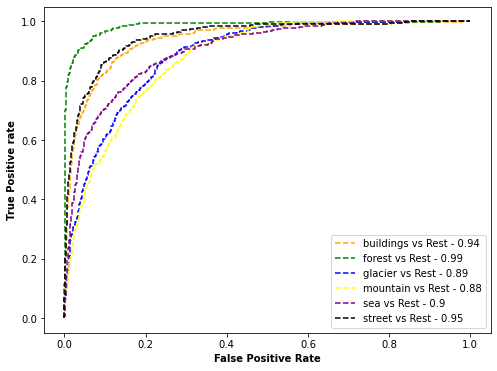

In [41]:
#Plotting ROC AUC Curve for multiclass
fpr = {}
tpr = {}
thresh ={}
auc = {}

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_proba[:,i], pos_label=i)
    test_prov = y_test.map(lambda x: 1 if x == i else 0)
    auc[i] = roc_auc_score(test_prov, y_proba[:,i])
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=class_names[0]+' vs Rest - '+str(round(auc[0],2)))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=class_names[1]+' vs Rest - '+str(round(auc[1],2)))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=class_names[2]+' vs Rest - '+str(round(auc[2],2)))
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label=class_names[3]+' vs Rest - '+str(round(auc[3],2)))
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label=class_names[4]+' vs Rest - '+str(round(auc[4],2)))
plt.plot(fpr[5], tpr[5], linestyle='--',color='black', label=class_names[5]+' vs Rest - '+str(round(auc[5],2)))
plt.xlabel('False Positive Rate', fontweight = 'bold')
plt.ylabel('True Positive rate', fontweight = 'bold')
plt.legend(loc='best')

# Forest class presented the highest AUC score, indicating that the model presented
# strong ability in distinguish the forest class from the rest (other classes).

## 5) Results

### A) Best Model

According to the accuracy and AUC scores calculated from the different deep learning model, the best model was model_2, given that it presented the highest score values (accuracy: 0.8197 ; AUC: 0.971), indicating that this model better classified images of Intel Image Classification dataset.

### B) Main Findings

1- Model_1 and, especially, model_2 presented high accuracy and AUC values (above 80 and 0.95), which indicates that these models can efficiently predict whether the images from the dataset (Intel image classification) belongs to the classes buildings, forest, glacier, mountain, sea, and street. Model_3, which was built using the deep learning architecture ResNet50, performed considerably worst for this dataset, given that it presented accuracy values below 65%.

2- By assessing validation/training loss and accuracy during the training epochs, it was observed that models 1 and 3 entered in overfitting. More precisely after 2 epochs for model_1 and after 6 epochs for model3. Overfitting was observed since. After these number of epochs, only the Train scores benefits from more training, given that only the train accuracy increases and train loss decreases after this time.The test accuracy remains the same after these number of epochs, while the loss increases, indicating overfitting.

3- As shown in the confusion matrices, the most of the misclassified images were from the class mountain, and buildings (true), mainly due to misclassification as glacier and streets (predicted), respectively. This pattern was observed for model_1 and model_2. Interestingly, the images from classes glacier and mountain were indeed very similar, which may impairs their recognition by the algorithm. The same scneario was observed for streets and buildings.

4- The ROC curve for each class suggested that the forest class presented the highest AUC score, in all models analyzed (1, 2, and 3), indicating that the model presented a strong ability in distinguish the forest class from the rest (other classes).

### C) Model's limitation and perspectives¶

* **Limitations:**

    1- Despite being a very good model given the metrics analyzed, the deep learning model_2 does not perfectly classified the true labels of the image validation subset. The model fails on classifying 20% of the validation dataset observations.

    2- Furthermore, model_2 could have been benefit from more train epochs, given the validation loss and validation accuracy indicates that tendency. The model was still increasing its validation accuracy over the epochs, as well as decreasing its validation loss.
    
    3- The very high computational cost to train convolutional deep learning models, such as those presented in this work, impairs the use of deeper networks or even longer epochs during the training routine.


* **Perspectives:**

    1- A possible strategy to improve the model should be increasing the number of initial images used to train the model, possibly through using image augmentation strategies such as sppining and cropping.

    2- Perform a grid search with different convolutional network hyperparameters and different competitive architectures may also benefit the model's accuracy.
    
    3- Use pre-trained networks could also benefit the model (transfer learning).